# Интересное про python

## Скорость Numpy

NDArray работает в разы быстрее благодаря способу хранения информации

In [1]:
import pandas as pd

In [2]:
a = [1, 2, 3, 300]

for i in range(len(a)-1):

    print(i, id(a[i]))
    print(i+1, id(a[i+1]))
    print('delta', id(a[i+1]) - id(a[i]))
    print('--')

0 4350321256
1 4350321288
delta 32
--
1 4350321288
2 4350321320
delta 32
--
2 4350321320
3 5233560208
delta 883238888
--


Python использует хитрые оптимизации и кэширует целые числа от -5 до 256 в **непрерывной** области памяти

In [3]:
id(256) - id(0), id(257) - id(0)

(8192, 883238536)

При повторном вызове строчки выше, мы получим другое значение во втором элементе ответа, так как python заново создаст объект 257 где-то в куче и расстояние между ним и объектом 0 уже будет другое

In [4]:
id(256) - id(0), id(257) - id(0)

(8192, 883239240)

## display()

In [5]:
a = [1, 2, 3]
b = a
del a
print(b)
# print(a)

[1, 2, 3]


In [6]:
a = [1, 2, 3]
b = a
b[0] = 10
print(a)

[10, 2, 3]


In [7]:
a = [1, 2, 3]
b = a[:]
b[0] = 10
print(a)

[1, 2, 3]


In [8]:
a = [2, 4, 6]
a

[2, 4, 6]

In [9]:
a

[2, 4, 6]

In [10]:
# Обновляем куда указывает имя "a", по хорошему старые данные должны затереться
a = [3, 5, 7]

In [11]:
# Так как в IPython есть специальный массив куда сказываются аутпуты ячеек,
# то старое содержимое "a" никуда не делось и всё равно весит в памяти
# Out[144]

In [12]:
df = pd.DataFrame()

In [13]:
df

""


In [14]:
# df.drop(colums=['a'], inplace=True)

In [15]:
display([1, 2, 3])

[1, 2, 3]

# Урок 3. Классификация

In [16]:
import numpy as np
import pandas as pd

## Смотрим на данные

In [17]:
# Качаем данные
# !gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

Датасет заявок на кредит с информацией о клиента и флагом одобрение или отказ по заявке

In [18]:
#Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [19]:
# Посмотрим на него
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Заведём константу, чтобы каждый раз не вспоминать как называется колонка с таргетом
TARGET = 'loan_status'

In [22]:
# Посмотрим на пропуски
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [23]:
df['age_bin'] = df['person_age'] #//6

<Axes: xlabel='age_bin'>

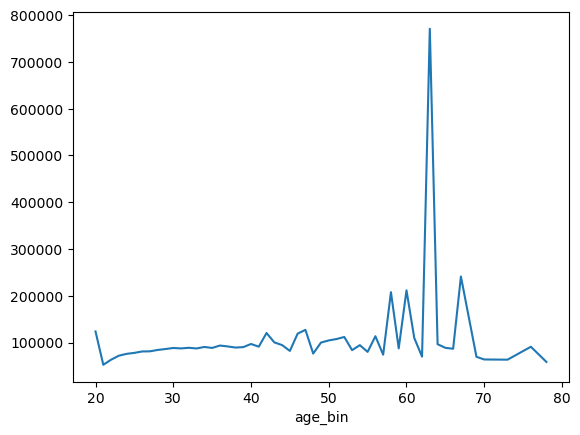

In [24]:
# Посмотрим на распределение среднего дохода в зависимости от возраста
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

<Axes: xlabel='age_bin'>

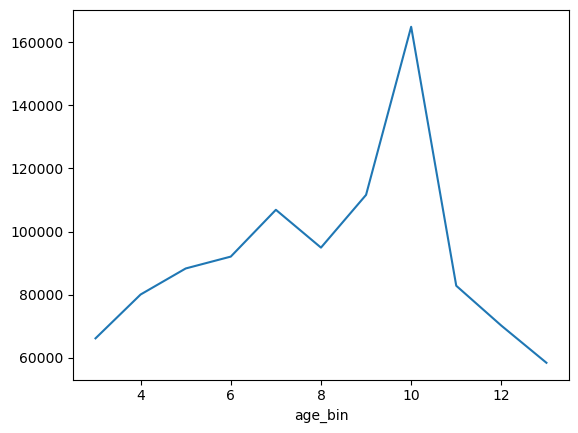

In [25]:
df['age_bin'] = df['person_age'] // 6
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

Пропусков нет - скучно :(

In [26]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [27]:
df.isna().sum()


person_age                         991
person_gender                        0
person_education                     0
person_income                     3000
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
age_bin                              0
dtype: int64

In [28]:
# Проверим гипотезы про случайность/неслучайность получившихся пустот

print('Target rate all:', df[TARGET].mean())

print('--'*20)

print('Target rate income null:', df[df['person_income'].isna()][TARGET].mean())
print('Target rate income not null:', df[df['person_income'].notna()][TARGET].mean())

print('--'*20)

print('Target rate age null:', df[df['person_age'].isna()][TARGET].mean())
print('Target rate age not null:', df[df['person_age'].notna()][TARGET].mean())

Target rate all: 0.2222222222222222
----------------------------------------
Target rate income null: 0.17266666666666666
Target rate income not null: 0.22576190476190477
----------------------------------------
Target rate age null: 0.2250252270433905
Target rate age not null: 0.22215910381967324


## Попробуем обучить LogisticRegression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [30]:
# Разобъем на тренировочную и тестовую выборки
train, test = train_test_split(df, test_size=0.25, random_state=43)

In [31]:
# Для простоты возьмём несколько числовых колонок в качестве факторов
features = ['loan_amnt', 'loan_int_rate'] # loan_amnt - сумма кредита, loan_int_rate - процентная ставка

In [32]:
X_train = train[features]
y_train = train[TARGET] #loan status - статус кредита (наш таргет)

X_test = test[features]
y_test = test[TARGET]

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [34]:
def least_squared_estimator(X, y, learn_intercept=False):
  X = np.array(X)
  if learn_intercept:
    X = np.concatenate([np.ones((X.shape[0], 1), ), X ], axis=1)
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y
  return coefs

In [35]:
coefs = least_squared_estimator(X_train, y_train, learn_intercept=True)
f = lambda x: coefs[0] + coefs[1] * x[:, 0] + coefs[2] * x[:, 1]

print(f)

<function <lambda> at 0x302e43740>


In [36]:
coefs

array([-3.15807260e-01,  4.23973811e-06,  4.52734577e-02])

In [37]:
train['predict'] = lr.predict(X_train)
test['predict'] = lr.predict(X_test)


train['predict_proba'] = lr.predict_proba(X_train)[:, 1]
test['predict_proba'] = lr.predict_proba(X_test)[:, 1]

In [38]:
train['predict_naive'] = f(X_train.values)
test['predict_naive'] = f(X_test.values)

In [39]:
import matplotlib as mpl

train_sample = train.sample(2500)
test_sample = test.sample(2500)

print(train_sample)

       person_age person_gender person_education  person_income  \
1370         23.0          male         Bachelor        42818.0   
18320        33.0          male      High School        60663.0   
43045        26.0          male      High School        35415.0   
7000         24.0          male      High School        32438.0   
32600        23.0        female         Bachelor        90987.0   
...           ...           ...              ...            ...   
1954         23.0          male        Associate       109345.0   
4558         26.0          male        Associate       116510.0   
21667        29.0          male      High School        47989.0   
44354        23.0          male         Bachelor        29390.0   
36707        29.0          male         Bachelor       126829.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
1370                0                  RENT     1000.0            VENTURE   
18320               9                  RE

Посмотрим как мы попали на Train

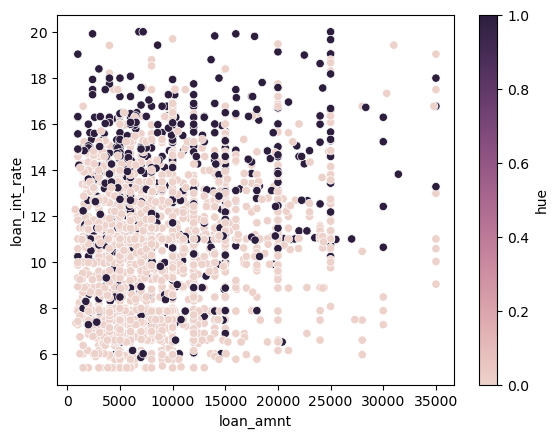

In [40]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

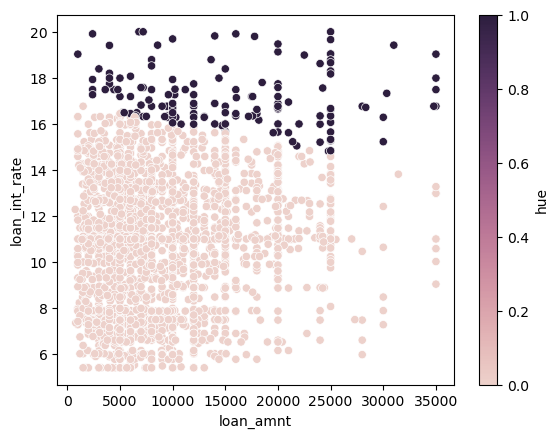

In [41]:
#плохой способ, predict 0,5
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

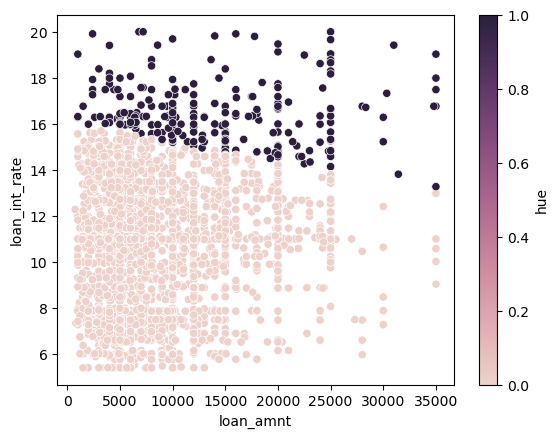

In [42]:
#хороший способ, порог настраиваем сами
train_sample['new_predict'] = (train_sample['predict_proba'] > 0.44).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

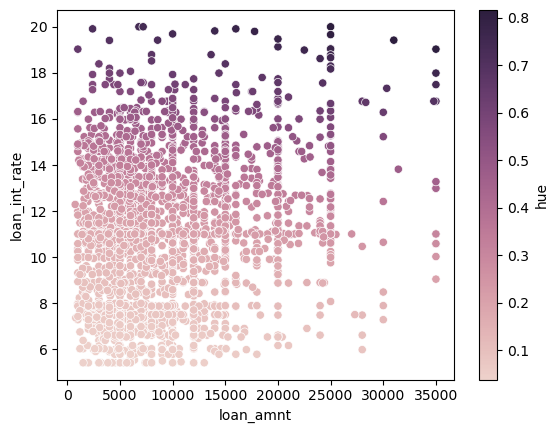

In [43]:
#градиент цвета, норм подход
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

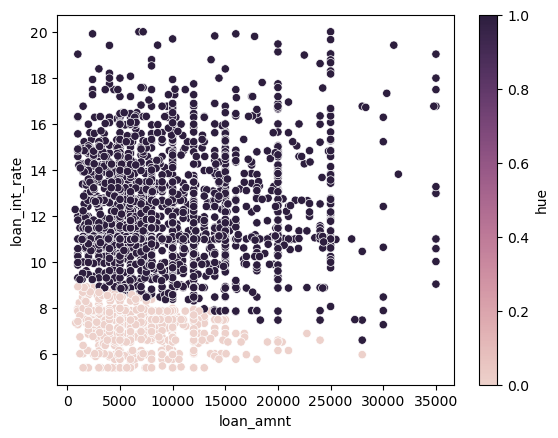

In [44]:
#наивный подход 
train_sample['new_predict'] = (train_sample['predict_naive'] > 0.1).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

Посмотрим как мы попали на Test

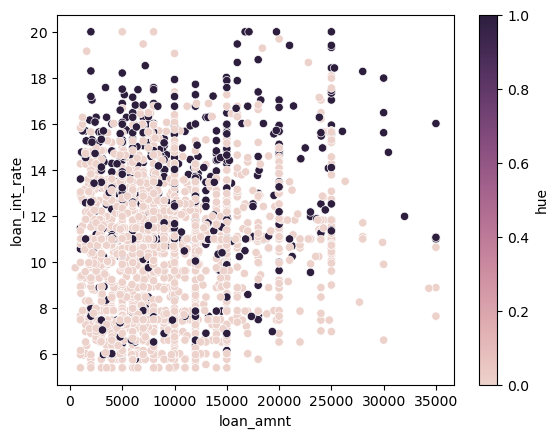

In [45]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

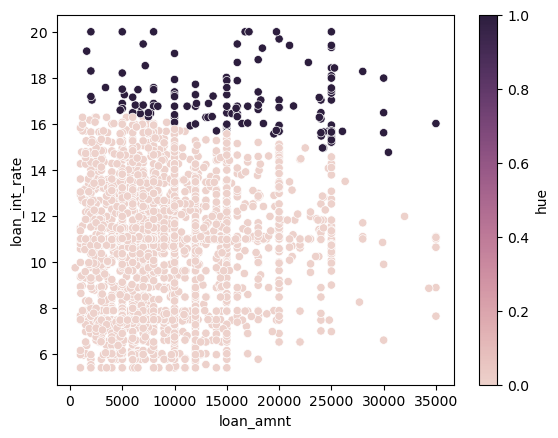

In [46]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

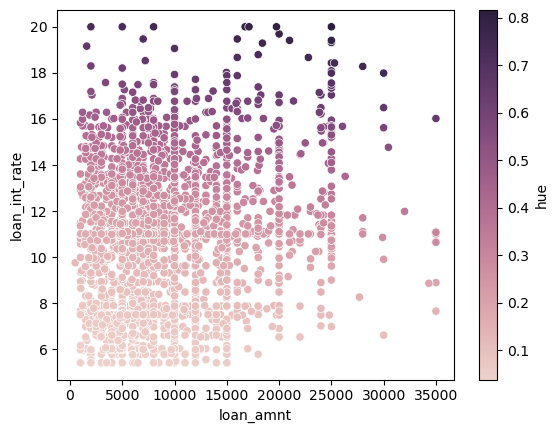

In [47]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

### Посчитаем Метрики

In [48]:
# Для начала заимпортим их
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

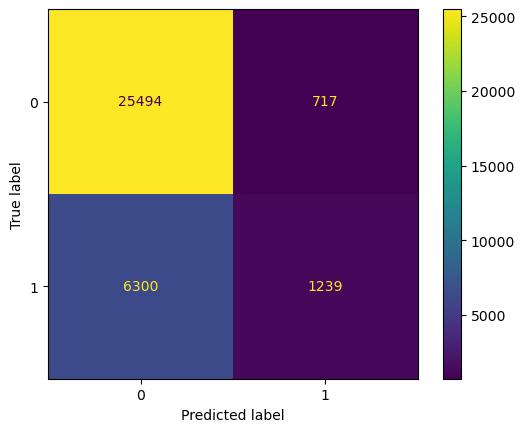

In [49]:
# Нарисуем Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(train[TARGET], train['predict'])).plot()

Верхняя левая (25494):
Истинный класс: 0
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 0, и модель правильно предсказала их как класс 0. Это Истинно Отрицательные (True Negatives, TN). Модель молодец.

Верхняя правая (717):
Истинный класс: 0
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 0, но модель ошибочно предсказала их как класс 1. Это Ложно Положительные (False Positives, FP), или "ошибка I рода". Модель ошиблась.

Нижняя левая (6300):
Истинный класс: 1
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 1, но модель ошибочно предсказала их как класс 0. Это Ложно Отрицательные (False Negatives, FN), или "ошибка II рода". Модель ошиблась (возможно, это самая критичная ошибка, если класс 1 - это что-то важное, например, болезнь).

Нижняя правая (1239):
Истинный класс: 1
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 1, и модель правильно предсказала их как класс 1. Это Истинно Положительные (True Positives, TP). Модель молодец.

In [50]:
# train
accuracy_score(train[TARGET], train['predict'])

0.7920888888888888

In [51]:
# train
accuracy_score(train[TARGET], [0] * train.shape[0])

0.7766222222222222

In [52]:
# test
accuracy_score(test[TARGET], test['predict'])

0.7953777777777777

In [53]:
accuracy_score(train[TARGET], (train['predict_proba'] > 0.44).astype(int))

0.7988740740740741

In [54]:
# train
precision_score(train[TARGET], train['predict'])

0.6334355828220859

In [55]:
# test
precision_score(test[TARGET], test['predict'])

0.6276083467094703

In [56]:
# train
recall_score(train[TARGET], train['predict'])

0.16434540389972144

In [57]:
# test
recall_score(test[TARGET], test['predict'])

0.1588785046728972

In [58]:
# train
roc_auc_score(train[TARGET], train['predict'])

0.5684952382895654

In [59]:
# test
roc_auc_score(test[TARGET], test['predict'])

0.5662409362595342

In [60]:
# train
roc_auc_score(train[TARGET], train['predict_proba'])

0.7223131917050427

In [61]:
# test
roc_auc_score(test[TARGET], test['predict_proba'])

0.7181920078610324

In [62]:
roc_auc_score(train[TARGET], train['predict_naive'])

0.7224718164513158

In [63]:
roc_auc_score(test[TARGET], test['predict_naive'])

0.7181826688628414

In [ ]:
from tqdm.auto import tqdm #отображение прогресс-бара
stats = [] # пустой список для хранения статистики
# Пробежимся по всем порогам от 0.01 до 1 с шагом 0.01
# и посчитаем accuracy, precision и recall для каждого порога
for threshold in tqdm(np.linspace(0.01, 1, 100)):
    stats.append({
        'threshold': threshold,
        'accuracy': accuracy_score(train[TARGET], (train['predict_proba'] > threshold).astype(int)),
        'accuracy_naive': accuracy_score(train[TARGET], (train['predict_naive'] > threshold).astype(int)),
        'precision': precision_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'precision_naive': precision_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
        'recall': recall_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'recall_naive': recall_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
    })
stats = pd.DataFrame(stats)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='threshold', ylabel='accuracy'>

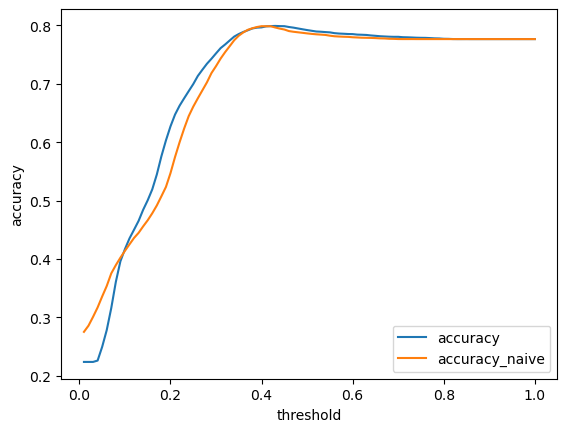

In [65]:
sns.lineplot(data=stats, x='threshold', y='accuracy', label='accuracy')
sns.lineplot(data=stats, x='threshold', y='accuracy_naive',  label='accuracy_naive')

<Axes: xlabel='threshold', ylabel='precision'>

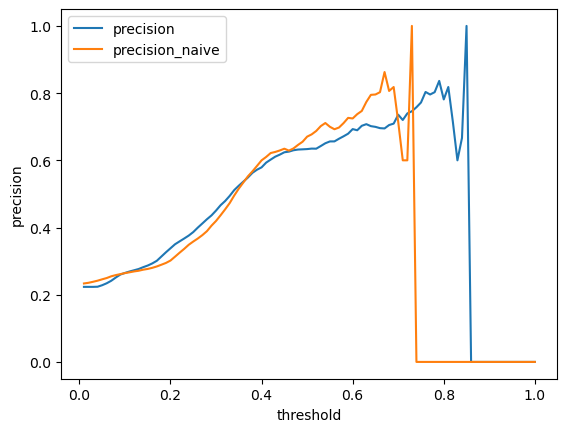

In [66]:
sns.lineplot(data=stats, x='threshold', y='precision', label='precision')
sns.lineplot(data=stats, x='threshold', y='precision_naive',  label='precision_naive')

<Axes: xlabel='threshold', ylabel='recall'>

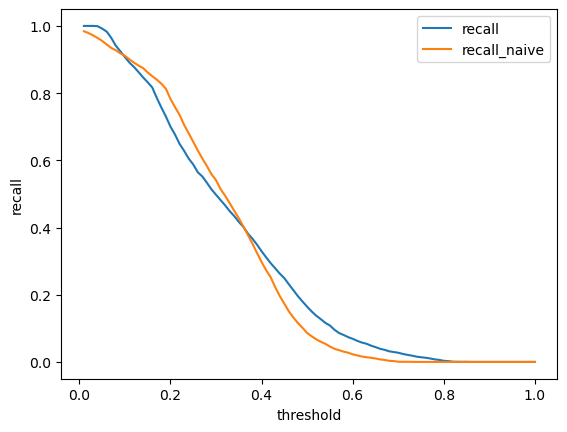

In [67]:
sns.lineplot(data=stats, x='threshold', y='recall', label='recall')
sns.lineplot(data=stats, x='threshold', y='recall_naive',  label='recall_naive')

### Таргет рейт в бинах скоров модели (калибровка)

In [68]:
# Посчитаем равномерные бины по скору на train
_, bins = pd.qcut(train['predict_proba'], q=20, retbins=True)

# Пременим их к train и test
train['proba_bin'] = pd.cut(train['predict_proba'], bins=bins)
test['proba_bin'] = pd.cut(test['predict_proba'], bins=bins)

In [69]:
# Внутри бинов посчитаем средний таргет и среднюю predict_proba
train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
display(train_stats)

/var/folders/t9/z5gctpm15fv8nllnr1v3gbpw0000gn/T/ipykernel_2305/2213546392.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


,predict_proba,loan_status
proba_bin,,
"(0.0377, 0.0567]",0.048403,0.060534
"(0.0567, 0.068]",0.062784,0.086002
"(0.068, 0.0776]",0.073074,0.090372
"(0.0776, 0.0884]",0.082339,0.089994
"(0.0884, 0.106]",0.096756,0.138361
"(0.106, 0.129]",0.117001,0.137173
"(0.129, 0.149]",0.139000,0.140828
"(0.149, 0.166]",0.158549,0.145294
"(0.166, 0.178]",0.171868,0.172146


In [70]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Create a base model and fit it first
base_model = LogisticRegression()
base_model.fit(train[['predict_proba']], train[TARGET])

# Create a calibration model with the fitted estimator
calibration = CalibratedClassifierCV(estimator=base_model, cv='prefit')
# Fit the calibration model
calibration.fit(train[['predict_proba']], train[TARGET])

# Use the calibrated model to predict probabilities
train['predict_proba_calib'] = calibration.predict_proba(train[['predict_proba']])[:, 1]
test['predict_proba_calib'] = calibration.predict_proba(test[['predict_proba']])[:, 1]

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

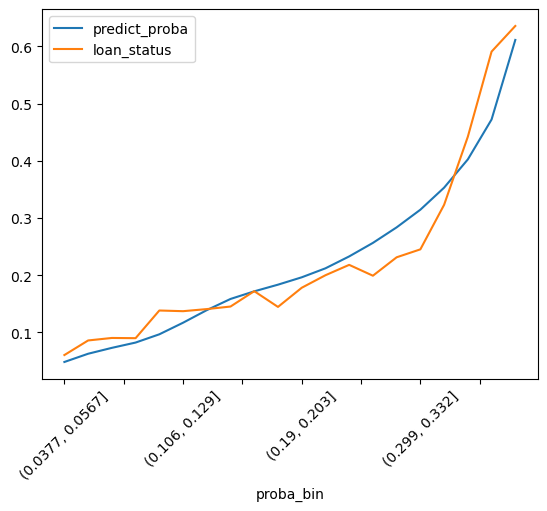

In [71]:
train_stats.plot()
plt.xticks(rotation=45)

/var/folders/t9/z5gctpm15fv8nllnr1v3gbpw0000gn/T/ipykernel_2305/1045931144.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

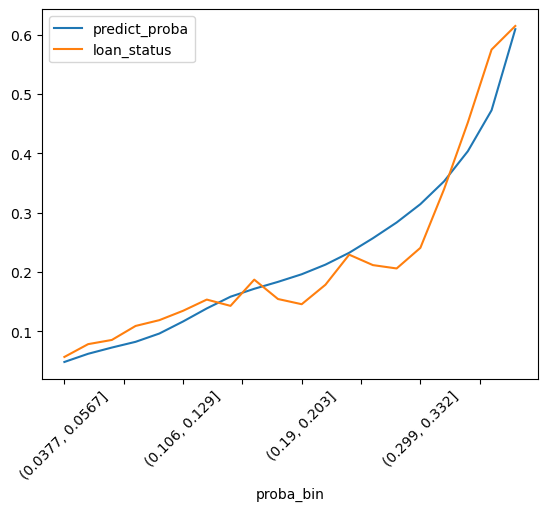

In [72]:
valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
valid_stats.plot()
plt.xticks(rotation=45)

# Домашнее Задание

In [73]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

## Logistic Regression (Своими Силами)

1. Дописать код градиентного спуска ниже
2. Поиграться с датасетом, предложеннным выше
3. Построить свою версию Логистической регресии (на каком-то одном числовом факторе без пропусков), сравнить результаты с LogisticRegression из SKlearn (Оценить метрики - ROC AUC, подобрать порог и Построить Confusion Matrix, а так же производные метрики от неё )
4. Заполнить пропуски, обработать категориальные переменные, обучить свою версию модели и Logistic Regression, сравнить качество между ними (см п.3) + с моделями из п.3 (как добавление бОльшего количества факторов влияет на качество модели)
5. *Поиграться с нормировкой данных (sklearn.model_selection.StandardScaler) оценить эффект на веса модели и её качество
6. Разбить факторы на Клиентские/Продуктовые/Кредитная История и построить по одной модели на каждом факторе. Затем построить мета-модель (интегральная модель) на трёх факторах - скорах метамоделях (дрейверы) - Сравнить результаты по каждому из драйеров + интегральной модели с одной моделью на всём факторном прстранстве.
7. *Привести график качества (ROC AUC) модели на фиксированной тренировочной выборке в зависимости от количества наблюдений, которые используются при обучении (train выборка). Например: 100, 500, 1000 и тд.

*- задания со звёздочкой, не обязательно, но довольно интересные

In [74]:
def sigmoid(z):
  return (1+np.exp(-z))**-1

def logloss(w, X, y):
    return np.log2(1 + np.exp(-(X @ w)*y)).mean()

In [75]:
# Реализуем собственный класс логистической регрессии
class MyLogisticRegression:
    def __init__(self, lr=1e-4, bias=True):
      self.bias = bool(bias)
      self.weights = None
      self.lr = lr

    def preproc_x(self, X):
      # Добавляем bias если требуется
      return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

    def fit(self, X, y, c_epoch=1000):
      # Инициализируем веса
      self.weights = np.ones(X.shape[1]+self.bias)

      self.X = self.preproc_x(X)
      self.y = y

      # Стохастический градиентный спуск
      # Итерируемся по количеству эпох
      for i in range(c_epoch):
        # Перешмешиваем наблюдения случайным образом
        ids = list(range(self.X.shape[0]))
        np.random.shuffle(ids)

        # итерируемся по наблюдениям
        for j in ids:
          p = sigmoid(np.dot(self.X[j], self.weights))
          # !TODO: Реализовать самостоятельно
          self.weights += self.lr * (p - self.y[j]) * self.X[j] # <производная dL по dW> (БЫЛА В СЛАЙДАХ)

        print(i , ':', logloss(self.weights, self.X, self.y))

    def predict_proba(self, X):
      X = self.preproc_x(X)
      return sigmoid((X @ self.weights)*1)

    def predict(self, X):
      X = self.preproc_x(X)
      preds = (sigmoid((X @ self.weights)*1) > 0.5).astype(int)
      preds[preds == 0] = -1
      return preds

In [76]:
# Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [77]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [78]:
# Разбить на train и test выборки
train, test = train_test_split(df , test_size=0.25, random_state=43)

features_income_crsc = ['person_income', 'credit_score']

my_X_train = train[features_income_crsc]
my_Y_train = train[TARGET]
my_X_test = test[features_income_crsc]
Y_test = test[TARGET]


In [79]:
my_lr = MyLogisticRegression(lr=1e-6)
sk_lr = LogisticRegression()

my_lr.fit(my_X_train.values, my_Y_train.values * 2 - 1, c_epoch=100)


0 : nan
1 : nan
2 : nan
3 : nan
4 : nan
5 : nan
6 : nan
7 : nan
8 : nan
9 : nan
10 : nan
11 : nan
12 : nan
13 : nan
14 : nan
15 : nan
16 : nan
17 : nan
18 : nan
19 : nan
20 : nan
21 : nan
22 : nan
23 : nan
24 : nan
25 : nan
26 : nan
27 : nan
28 : nan
29 : nan
30 : nan
31 : nan
32 : nan
33 : nan
34 : nan
35 : nan
36 : nan
37 : nan
38 : nan
39 : nan
40 : nan
41 : nan
42 : nan
43 : nan
44 : nan
45 : nan
46 : nan
47 : nan
48 : nan
49 : nan
50 : nan
51 : nan
52 : nan
53 : nan
54 : nan
55 : nan
56 : nan
57 : nan
58 : nan
59 : nan
60 : nan
61 : nan
62 : nan
63 : nan
64 : nan
65 : nan
66 : nan
67 : nan
68 : nan
69 : nan
70 : nan
71 : nan
72 : nan
73 : nan
74 : nan
75 : nan
76 : nan
77 : nan
78 : nan
79 : nan
80 : nan
81 : nan
82 : nan
83 : nan
84 : nan
85 : nan
86 : nan
87 : nan
88 : nan
89 : nan
90 : nan
91 : nan
92 : nan
93 : nan
94 : nan
95 : nan
96 : nan
97 : nan
98 : nan
99 : nan


In [80]:

train['my_predict'] = my_lr.predict(my_X_train.values)
train['my_predict_proba'] = my_lr.predict_proba(my_X_train.values) 

In [81]:
my_train_sample = train.sample(2500)
my_test_sample = test.sample(2500)

print(my_train_sample)

       person_age person_gender person_education  person_income  \
193          24.0        female        Associate        82741.0   
13487        26.0        female        Associate        97186.0   
44493        26.0        female         Bachelor        53400.0   
8971         25.0        female        Associate        73054.0   
36149        36.0        female         Bachelor        90820.0   
...           ...           ...              ...            ...   
19527        32.0          male      High School        60203.0   
13902        22.0        female           Master        39399.0   
30950        37.0          male      High School        52436.0   
5700         23.0        female      High School       166749.0   
13848        26.0        female           Master       117096.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
193                 0                  RENT    25000.0           PERSONAL   
13487               4              MORTGA

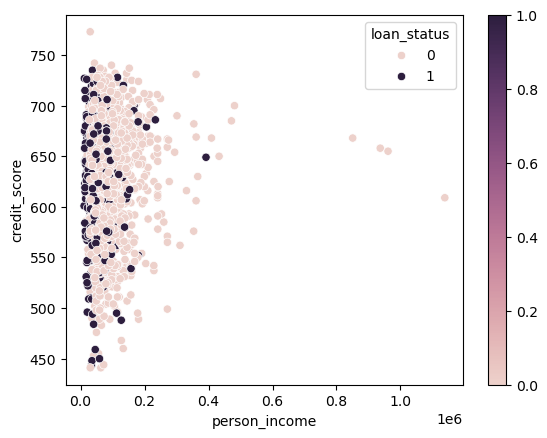

In [82]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
my_scatter = sns.scatterplot(data=train_sample, x='person_income', y='credit_score', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend=True)
cbar = plt.colorbar(sm, ax = plt.gca())
# cbar.set_label('hue')